<a href="https://colab.research.google.com/github/nnajeh/VAE/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
cd /content/drive/MyDrive///VAE

/content/drive/MyDrive/SAMPLES/Segmentation/VAE


In [ ]:
#@title Import Libraries

In [3]:
!pip install -q torch_snippets
from torch_snippets import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import torchvision.datasets as dataset

import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
device = 'cuda' if torch.cuda.is_available() else 'cpu'

     |████████████████████████████████| 42 kB 974 kB/s 
     |████████████████████████████████| 10.1 MB 6.6 MB/s 
     |████████████████████████████████| 211 kB 39.2 MB/s 
     |████████████████████████████████| 56 kB 3.3 MB/s 
     |████████████████████████████████| 57 kB 4.3 MB/s 
     |████████████████████████████████| 51 kB 5.9 MB/s 


2021-09-09 20:30:35.732 | WARNING  | torch_snippets:<module>:13 - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego'


In [ ]:
#@title Define dataset

In [ ]:
train_dataset = datasets.MNIST(root='MNIST/', train=True, transform=transforms.ToTensor(), download=False)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=64, shuffle=True)

In [5]:
test_dataset = datasets.MNIST(root='MNIST/', train=False, transform=transforms.ToTensor(), download=False)
test_loader = torch.utils.data.DataLoader(dataset= test_dataset, batch_size=64, shuffle=False)


In [102]:
#@title Define network

In [6]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        self.d1 = nn.Linear(x_dim, h_dim1)
        self.d2 = nn.Linear(h_dim1, h_dim2)
        self.d31 = nn.Linear(h_dim2, z_dim)
        self.d32 = nn.Linear(h_dim2, z_dim)
        self.d4 = nn.Linear(z_dim, h_dim2)
        self.d5 = nn.Linear(h_dim2, h_dim1)
        self.d6 = nn.Linear(h_dim1, x_dim)
    def encoder(self, x):
        h = F.relu(self.d1(x))
        h = F.relu(self.d2(h))
        return self.d31(h), self.d32(h)
    def sampling(self, mean, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mean)
    def decoder(self, z):
        h = F.relu(self.d4(z))
        h = F.relu(self.d5(h))
        return F.sigmoid(self.d6(h))
    def forward(self, x):
        mean, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mean, log_var)
        return self.decoder(z), mean, log_var

In [7]:
#@title Define functions for train

In [8]:
def train_batch(data, model, optimizer, loss_function):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon_batch, data, mean, log_var)
    loss.backward()
    optimizer.step()
    return loss, mse, kld, log_var.mean(), mean.mean()

In [9]:
#@title Define functions for validation


In [10]:
@torch.no_grad()
def validate_batch(data, model, loss_function):
    model.eval()
    data = data.to(device)
    recon, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon, data, mean, log_var)
    return loss, mse, kld, log_var.mean(), mean.mean()

In [11]:
#@title Define Loss Function


In [12]:
def loss_function(recon_x, x, mean, log_var):
    RECON = F.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return RECON + KLD, RECON, KLD

In [13]:
#@title Training

In [16]:
vae = VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=50).to(device)
optimizer = optim.AdamW(vae.parameters(), lr=1e-4)

In [17]:
n_epochs = 20
log = Report(n_epochs)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


EPOCH: 1.000	train_loss: 3662.172	train_kld: 76.182	train_recon: 3585.990	train_log_var: 0.004	train_mean: 0.003	val_loss: 3202.264	val_kld: 93.190	val_recon: 3109.075	val_log_var: -0.051	val_mean: 0.000	(18.78s - 356.88s remaining)


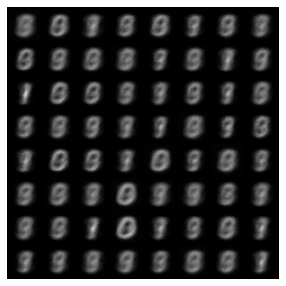

EPOCH: 2.000	train_loss: 3069.162	train_kld: 167.725	train_recon: 2901.436	train_log_var: -0.094	train_mean: 0.001	val_loss: 2897.633	val_kld: 272.307	val_recon: 2625.326	val_log_var: -0.143	val_mean: -0.003	(36.32s - 326.86s remaining)


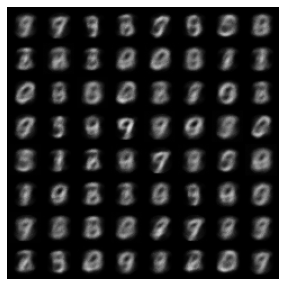

EPOCH: 3.000	train_loss: 2803.805	train_kld: 315.868	train_recon: 2487.938	train_log_var: -0.182	train_mean: -0.001	val_loss: 2683.963	val_kld: 366.612	val_recon: 2317.351	val_log_var: -0.216	val_mean: -0.007	(53.77s - 304.72s remaining)


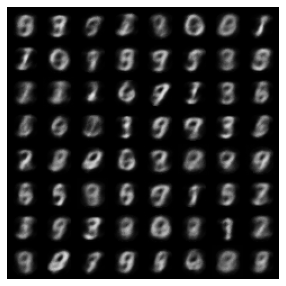

EPOCH: 4.000	train_loss: 2629.651	train_kld: 398.389	train_recon: 2231.263	train_log_var: -0.233	train_mean: -0.001	val_loss: 2531.661	val_kld: 434.252	val_recon: 2097.410	val_log_var: -0.254	val_mean: -0.007	(71.15s - 284.62s remaining)


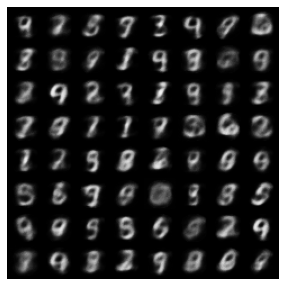

EPOCH: 5.000	train_loss: 2501.190	train_kld: 454.071	train_recon: 2047.119	train_log_var: -0.267	train_mean: 0.000	val_loss: 2415.115	val_kld: 480.549	val_recon: 1934.566	val_log_var: -0.282	val_mean: -0.014	(88.57s - 265.72s remaining)


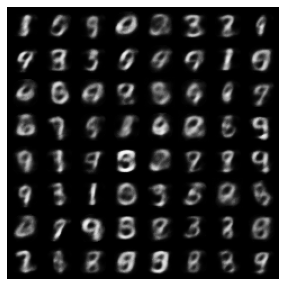

EPOCH: 6.000	train_loss: 2391.090	train_kld: 492.685	train_recon: 1898.405	train_log_var: -0.290	train_mean: -0.000	val_loss: 2323.510	val_kld: 526.027	val_recon: 1797.484	val_log_var: -0.315	val_mean: -0.003	(106.30s - 248.04s remaining)


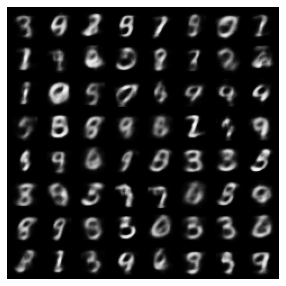

EPOCH: 7.000	train_loss: 2313.077	train_kld: 518.771	train_recon: 1794.306	train_log_var: -0.307	train_mean: -0.000	val_loss: 2251.098	val_kld: 537.931	val_recon: 1713.167	val_log_var: -0.316	val_mean: -0.015	(124.29s - 230.83s remaining)


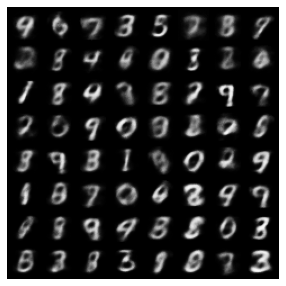

EPOCH: 8.000	train_loss: 2252.457	train_kld: 539.515	train_recon: 1712.942	train_log_var: -0.321	train_mean: -0.000	val_loss: 2197.964	val_kld: 554.847	val_recon: 1643.117	val_log_var: -0.329	val_mean: -0.008	(142.06s - 213.09s remaining)


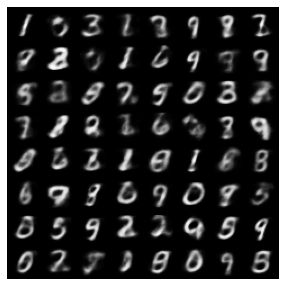

EPOCH: 9.000	train_loss: 2199.551	train_kld: 557.761	train_recon: 1641.790	train_log_var: -0.333	train_mean: -0.001	val_loss: 2152.559	val_kld: 556.149	val_recon: 1596.410	val_log_var: -0.329	val_mean: -0.016	(159.94s - 195.48s remaining)


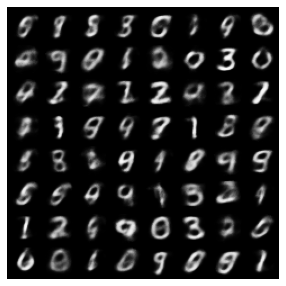

EPOCH: 10.000	train_loss: 2153.417	train_kld: 573.658	train_recon: 1579.759	train_log_var: -0.343	train_mean: -0.001	val_loss: 2106.220	val_kld: 587.805	val_recon: 1518.415	val_log_var: -0.353	val_mean: -0.002	(177.80s - 177.80s remaining)


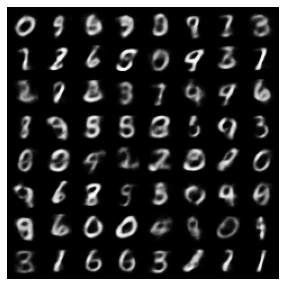

EPOCH: 11.000	train_loss: 2116.615	train_kld: 587.379	train_recon: 1529.236	train_log_var: -0.353	train_mean: -0.001	val_loss: 2073.510	val_kld: 599.521	val_recon: 1473.990	val_log_var: -0.361	val_mean: -0.007	(195.89s - 160.27s remaining)


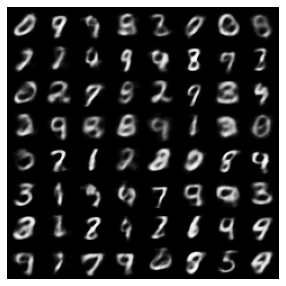

EPOCH: 12.000	train_loss: 2086.278	train_kld: 598.072	train_recon: 1488.206	train_log_var: -0.361	train_mean: -0.001	val_loss: 2051.100	val_kld: 606.762	val_recon: 1444.338	val_log_var: -0.360	val_mean: -0.007	(213.85s - 142.57s remaining)


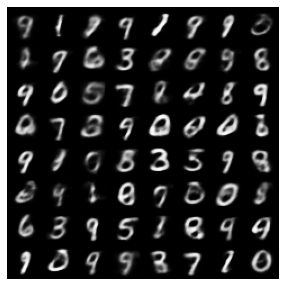

EPOCH: 13.000	train_loss: 2062.249	train_kld: 609.020	train_recon: 1453.229	train_log_var: -0.369	train_mean: -0.001	val_loss: 2025.247	val_kld: 618.832	val_recon: 1406.415	val_log_var: -0.373	val_mean: -0.005	(231.65s - 124.73s remaining)


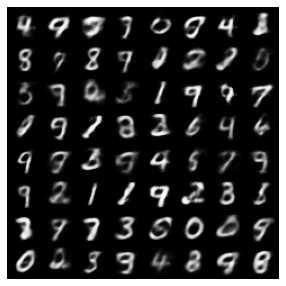

EPOCH: 14.000	train_loss: 2042.068	train_kld: 619.103	train_recon: 1422.965	train_log_var: -0.376	train_mean: -0.000	val_loss: 2001.057	val_kld: 622.971	val_recon: 1378.086	val_log_var: -0.379	val_mean: -0.006	(249.79s - 107.05s remaining)


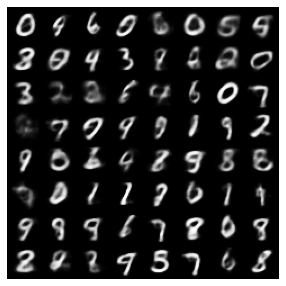

EPOCH: 15.000	train_loss: 2021.250	train_kld: 626.009	train_recon: 1395.241	train_log_var: -0.381	train_mean: -0.000	val_loss: 1991.279	val_kld: 630.381	val_recon: 1360.898	val_log_var: -0.383	val_mean: -0.004	(268.05s - 89.35s remaining)


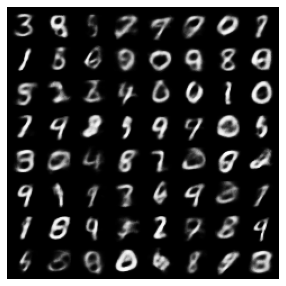

EPOCH: 16.000	train_loss: 2007.755	train_kld: 635.656	train_recon: 1372.098	train_log_var: -0.387	train_mean: -0.000	val_loss: 1973.097	val_kld: 651.436	val_recon: 1321.660	val_log_var: -0.400	val_mean: -0.008	(286.13s - 71.53s remaining)


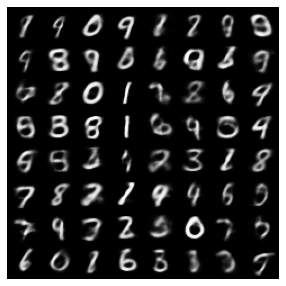

EPOCH: 17.000	train_loss: 1991.397	train_kld: 642.632	train_recon: 1348.765	train_log_var: -0.392	train_mean: -0.000	val_loss: 1961.813	val_kld: 638.723	val_recon: 1323.089	val_log_var: -0.393	val_mean: -0.007	(304.60s - 53.75s remaining)


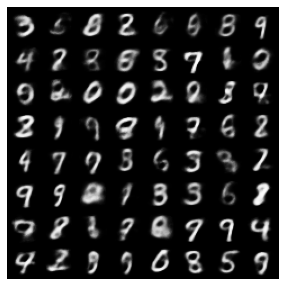

EPOCH: 18.000	train_loss: 1976.250	train_kld: 649.634	train_recon: 1326.616	train_log_var: -0.396	train_mean: -0.001	val_loss: 1949.557	val_kld: 632.208	val_recon: 1317.349	val_log_var: -0.388	val_mean: -0.009	(322.76s - 35.86s remaining)


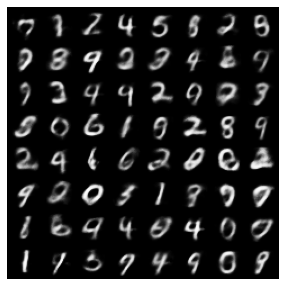

EPOCH: 19.000	train_loss: 1961.538	train_kld: 654.625	train_recon: 1306.914	train_log_var: -0.399	train_mean: -0.001	val_loss: 1939.629	val_kld: 653.011	val_recon: 1286.618	val_log_var: -0.396	val_mean: -0.001	(340.68s - 17.93s remaining)


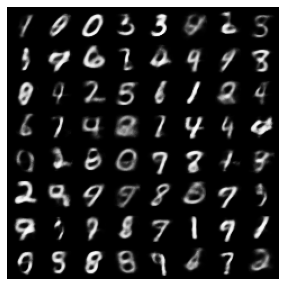

EPOCH: 20.000	train_loss: 1951.230	train_kld: 662.358	train_recon: 1288.872	train_log_var: -0.404	train_mean: -0.001	val_loss: 1921.985	val_kld: 676.134	val_recon: 1245.852	val_log_var: -0.408	val_mean: -0.002	(358.89s - 0.00s remaining)


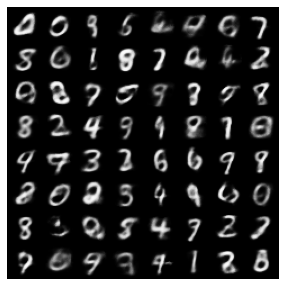

In [18]:
for epoch in range(n_epochs):

    N = len(train_loader)
    for batch_idx, (data, _) in enumerate(train_loader):
        loss, recon, kld, log_var, mean = train_batch(data, vae, optimizer, loss_function)
        pos = epoch + (1+batch_idx)/N
        log.record(pos, train_loss=loss, train_kld=kld, train_recon=recon, train_log_var=log_var, train_mean=mean, end='\r')
        
    N = len(test_loader)
    for batch_idx, (data, _) in enumerate(test_loader):
        loss, recon, kld, log_var, mean = validate_batch(data, vae, loss_function)
        pos = epoch + (1+batch_idx)/N
        log.record(pos, val_loss=loss, val_kld=kld, val_recon=recon, val_log_var=log_var, val_mean=mean, end='\r')
        
    log.report_avgs(epoch+1)
    with torch.no_grad():
        z = torch.randn(64, 50).to(device)
        sample = vae.decoder(z).to(device)
        images = make_grid(sample.view(64, 1, 28, 28)).permute(1,2,0)
        show(images)

100%|██████████| 121/121 [00:00<00:00, 147.89it/s]


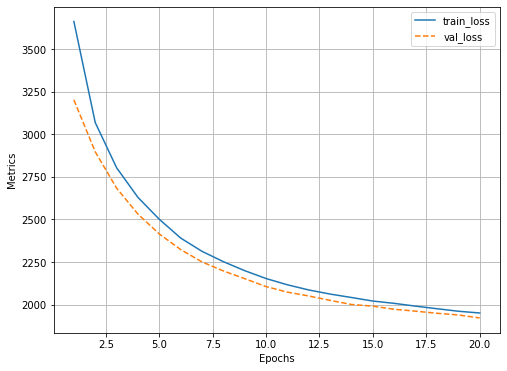

In [19]:
log.plot_epochs(['train_loss','val_loss'])